<a href="https://colab.research.google.com/github/maskot1977/PythonCourse2019/blob/master/reinforcement_learning_to_travel_Japan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

あなたにはこれから、北海道の札幌から沖縄の那覇まで旅行していただきます。強化学習で。

# グラフ探索手法を使えばいいんじゃない？

ええ、その通りです。グラフ探索手法を使えば簡単に求まります。詳しくは

* [グラフ理論の基礎](https://qiita.com/maskot1977/items/e1819b7a1053eb9f7d61)
* [グラフ理論の基礎をmatplotlibアニメーションで](https://qiita.com/maskot1977/items/b55c6d1c85bcf0ec0d08)

を見てください。でもここでは、強化学習について今日から学習していただきます。


# 日本縦断旅行の目的

* 目的１：ゴールにたどり着く
* 目的２：ゴールまでの最短経路を発見する



# 日本の県庁所在地データ

## 県庁所在地の緯度・経度

In [0]:
import urllib.request
url = 'https://raw.githubusercontent.com/maskot1977/ipython_notebook/master/toydata/location.txt'
urllib.request.urlretrieve(url, 'location.txt') # データのダウンロード

('location.txt', <http.client.HTTPMessage at 0x104892be0>)

In [0]:
import pandas as pd
location = pd.read_csv('location.txt').values
pd.DataFrame(location)

,0,1,2
0,Sapporo,43.0642,141.347
1,Aomori,40.8244,140.74
2,Morioka,39.7036,141.153
3,Sendai,38.2689,140.872
4,Akita,39.7186,140.102
5,Yamagata,38.2406,140.363
6,Fukushima,37.75,140.468
7,Mito,36.3414,140.447
8,Utsunomiya,36.5658,139.884
9,Maebashi,36.3911,139.061


/Users/kot/miniconda3/envs/py3new/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


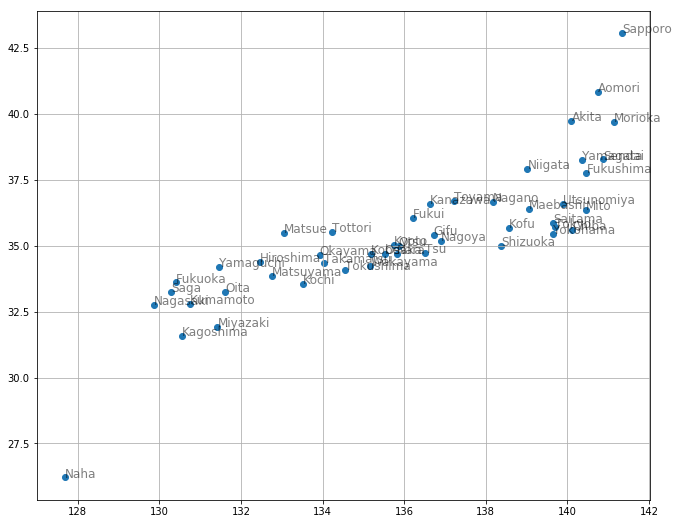

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 9))
plt.scatter(location[:, 2], location[:, 1])
for city, y, x in location:
    plt.text(x, y, city, alpha=0.5, size=12)
plt.grid()

## 県庁所在地間の距離行列

In [0]:
import numpy as np
from scipy.spatial import distance

dist_mat = distance.cdist(location[:, 1:], location[:, 1:], metric='euclidean') # ユークリッド距離

In [0]:
import pandas as pd
def visualize_matrix(matrix):
    plt.figure(figsize=(12, 10))
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.coolwarm)
    plt.colorbar()
    tick_marks = np.arange(len(matrix))
    plt.xticks(tick_marks, matrix.columns, rotation=90)
    plt.yticks(tick_marks, matrix.columns)
    plt.tight_layout()

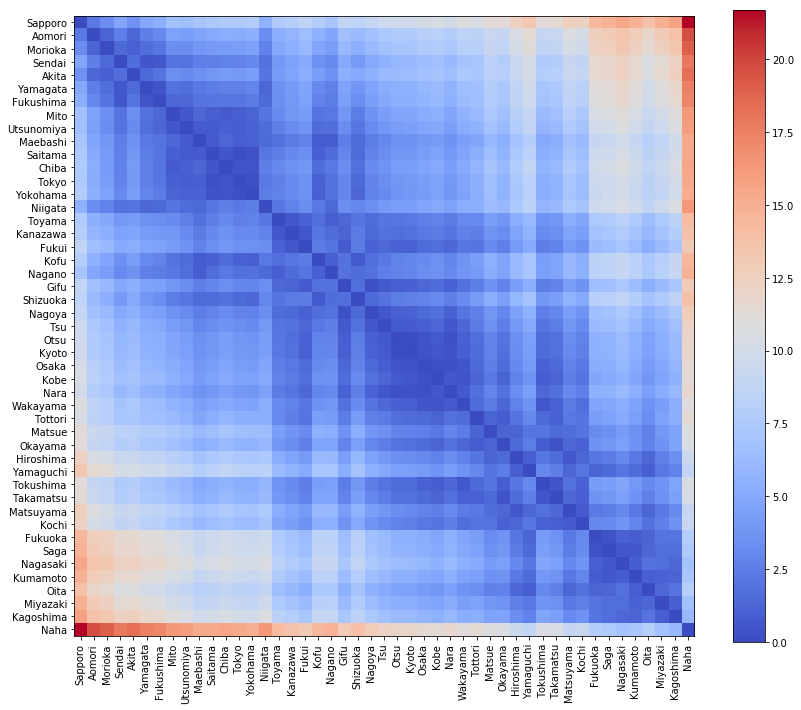

In [0]:
visualize_matrix(pd.DataFrame(dist_mat, columns=location[:, 0]))

## 県庁所在地間の徒歩移動時間

In [0]:
url = 'https://raw.githubusercontent.com/maskot1977/ipython_notebook/master/toydata/walk.txt'
urllib.request.urlretrieve(url, 'walk.txt')

('walk.txt', <http.client.HTTPMessage at 0x115ad1128>)

In [0]:
walk = pd.read_csv('walk.txt', sep='\s+')
walk

,Town1,Town2,Hour,Ferry
0,Sapporo,Aomori,55,True
1,Akita,Aomori,36,NaN
2,Akita,Sendai,45,NaN
3,Akita,Niigata,52,NaN
4,Yamagata,Aomori,75,NaN
5,Morioka,Aomori,37,NaN
6,Morioka,Akita,24,NaN
7,Yamagata,Akita,41,NaN
8,Yamagata,Morioka,46,NaN
9,Yamagata,Sendai,14,NaN


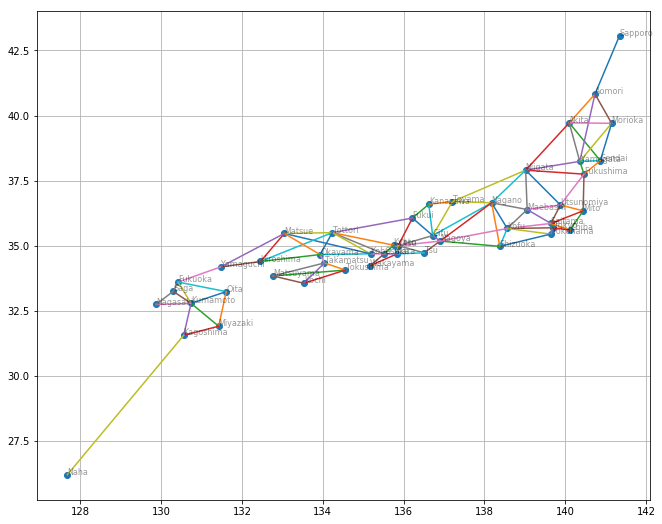

In [0]:
plt.figure(figsize=(11, 9))
for city, y, x in location:
    plt.text(x, y, city, alpha=0.4, size=8)
    
for w in walk.values:
    t1 = np.where(location[:, 0] == w[0])[0][0]
    t2 = np.where(location[:, 0] == w[1])[0][0]
    n1, y1, x1 = location[t1]
    n2, y2, x2 = location[t2]
    plt.plot([x1, x2], [y1, y2])
    
plt.scatter(location[:, 2], location[:, 1])
plt.grid()

## 取れる行動の選択肢を theta で表現

In [0]:
import numpy as np
theta_zero = np.full((len(location), len(location)), np.nan)
theta_zero

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [0]:
for w in walk.values:
    i = np.where(location[:, 0] == w[0])[0][0]
    j = np.where(location[:, 0] == w[1])[0][0]
    theta_zero[i, j] = 1
    theta_zero[j, i] = 1

## 取る行動の確率を pi で表現

In [0]:
def normalize_pi(theta):
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
        
    return np.nan_to_num(pi)

In [0]:
pi_zero = normalize_pi(theta_zero)

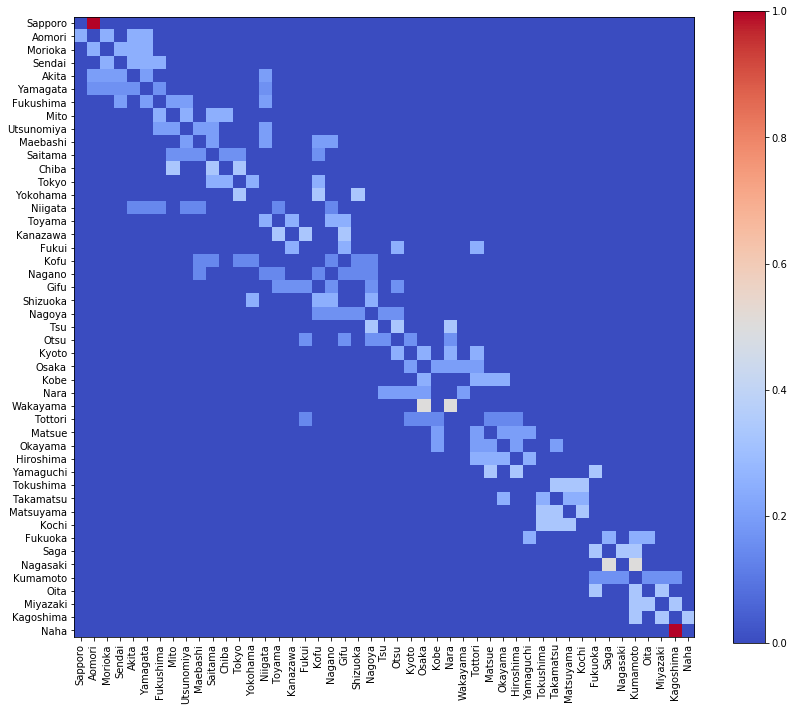

In [0]:
visualize_matrix(pd.DataFrame(pi_zero, columns=location[:, 0]))

# ランダムウォーク

## 次の行動を確率的に選ぶ

In [0]:
def get_next(town, pi):
    return np.random.choice(range(len(pi)), p=pi[town, :])

In [0]:
get_next(12, pi_zero)

11

## ランダムウォークによる探索

In [0]:
def explore(pi, start=0, goal=46):
    route = [start]
    town = start
    while True:
        next_town = get_next(town, pi)
        if next_town in route:
            break
        route.append(next_town)
        if next_town == goal:
            break
        else:
            town = next_town
    return route

In [0]:
route = explore(pi_zero)
route

[0, 1]

In [0]:
[location[i, 0] for i in route]

['Sapporo', 'Aomori']

## 探索結果の評価指標

In [0]:
def evaluate(route, goal=46):
    dist_goal = dist_mat[route[-1], goal]
    len_route = sum([dist_mat[route[i], route[i + 1]] for i in range(len(route) - 1)])
    return [dist_goal, len_route]

In [0]:
route = explore(pi_zero)
[location[i, 0] for i in route], evaluate(route)

(['Sapporo', 'Aomori', 'Akita', 'Morioka'],
 [19.065371687019375, 4.647044270414716])

## 探索実行

In [0]:
def is_best_ever():
    if best_dist_goal >= dist_goal:
        if best_dist_goal > dist_goal:
            return True
        elif best_len_route > len_route:
            return True
        else:
            return False
    else:
        return False

In [0]:
%%time
pi = pi_zero.copy()
theta = theta_zero.copy()

best_dist_goal = 1000000
best_len_route = 1000000

dist_goal_history0 = []
len_route_history0 = []
best_route0 = []
for itera in range(50000):
    route = explore(pi)
    dist_goal, len_route = evaluate(route)
    dist_goal_history0.append(dist_goal)
    len_route_history0.append(len_route)
    
    if is_best_ever():
        best_dist_goal = dist_goal
        best_len_route = len_route
        best_route0 = route

CPU times: user 8.95 s, sys: 109 ms, total: 9.06 s
Wall time: 9.52 s


## 探索結果

In [0]:
def draw_histgrams(dist_goal_history, len_route_history):
    plt.figure(figsize=(max(len_route_history) / 4, max(dist_goal_history) / 4))
    x_max = max(dist_goal_history + len_route_history)
    ax = plt.subplot(2,1,1)
    ax.hist(dist_goal_history, label='dist_goal', bins=20)
    ax.set_xlim([0, x_max])
    ax.grid()
    ax.legend()
    ax = plt.subplot(2,1,2)
    ax.hist(len_route_history, label='len_route', bins=20)
    ax.set_xlim([0, x_max])
    ax.grid()
    ax.legend()

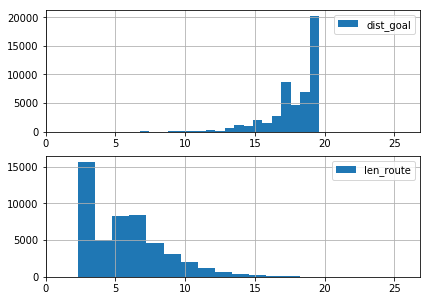

In [0]:
draw_histgrams(dist_goal_history0, len_route_history0)

In [0]:
def draw_scatter(dist_goal_history, len_route_history):
    plt.figure(figsize=(max(len_route_history) / 4, max(dist_goal_history) / 4))
    plt.scatter(len_route_history, dist_goal_history, alpha=0.5)
    plt.ylabel('dist_goal')
    plt.xlabel('len_route')
    plt.ylim([0, max(dist_goal_history) + 1])
    plt.xlim([0, max(len_route_history) + 1])
    plt.grid()
    plt.show()

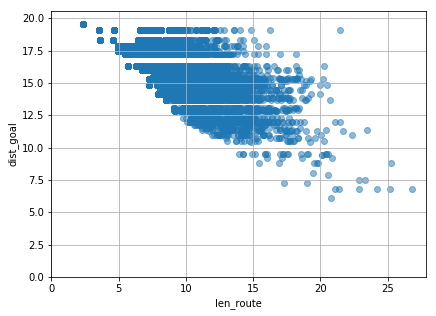

In [0]:
draw_scatter(dist_goal_history0, len_route_history0)

In [0]:
def visualize_history(history, interval=50, window=50):
    plt.plot(range(0, len(history), interval), 
             [np.array(history)[:i].max() for i in range(len(history)) if (i%interval) == 1], label='max')
    plt.plot(range(window, len(history)+window, interval), 
             [np.array(history)[i:i + window].mean() for i in range(len(history)) if (i%interval) == 1], 
             label='mean(recent)')
    plt.plot(range(0, len(history), interval), 
             [np.array(history)[:i].mean() for i in range(len(history)) if (i%interval) == 1], label='mean')
    plt.plot(range(0, len(history), interval), 
             [np.array(history)[:i].min() for i in range(len(history)) if (i%interval) == 1], label='min')
    plt.legend()
    plt.grid()
    plt.show()

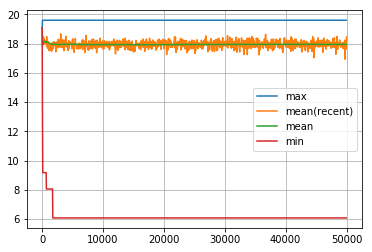

In [0]:
visualize_history(dist_goal_history0)

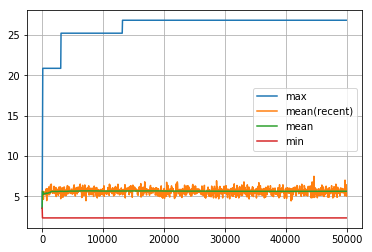

In [0]:
visualize_history(len_route_history0)

In [0]:
def draw_route(route):
    plt.figure(figsize=(11, 9))
    for i in route:
        plt.text(location[i, 2], location[i, 1], location[i, 0], alpha=0.4, size=12)
    plt.grid()
    plt.plot([location[i][2] for i in route], [location[i][1] for i in route])
    plt.ylabel('latitude')
    plt.xlabel('longitude')
    plt.show()

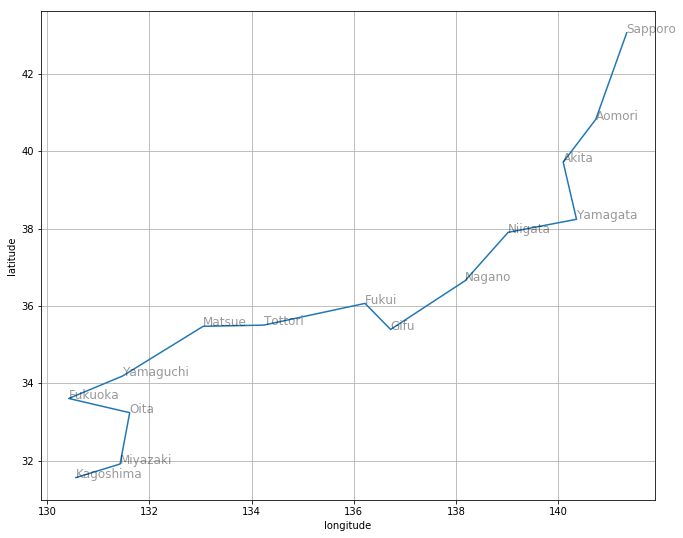

In [0]:
draw_route(best_route0)

# 方策勾配法

Policy gradient method

In [0]:
def update_pi(pi, route, goal=46, eta=0.1):
    new_pi = pi.copy()
    for i in range(len(route) - 1):
        town1 = route[i]
        town2 = route[i + 1]
        new_pi[town1, town2] +=  eta / (dist_mat[route[-1], goal] + 1)
    
    return normalize_pi(new_pi)

In [0]:
%%time
pi = pi_zero.copy()

best_dist_goal = 1000000
best_len_route = 1000000

dist_goal_history1 = []
len_route_history1 = []
best_route1 = []
for itera in range(50000):
    route = explore(pi)
    dist_goal, len_route = evaluate(route)
    dist_goal_history1.append(dist_goal)
    len_route_history1.append(len_route)
        
    pi = update_pi(pi, route)
    
    if is_best_ever():
        best_dist_goal = dist_goal
        best_len_route = len_route
        best_route1 = route

CPU times: user 1min 4s, sys: 207 ms, total: 1min 4s
Wall time: 1min 4s


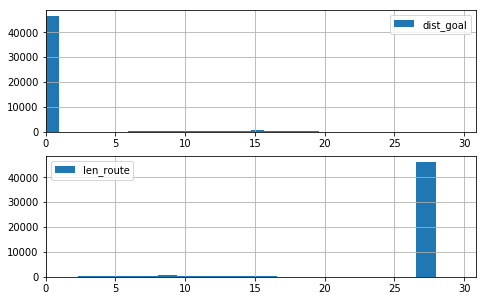

In [0]:
draw_histgrams(dist_goal_history1, len_route_history1)

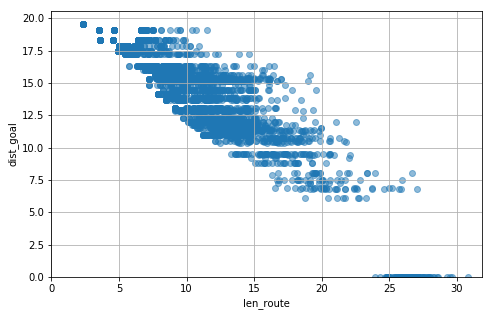

In [0]:
draw_scatter(dist_goal_history1, len_route_history1)

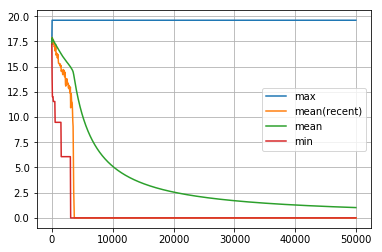

In [0]:
visualize_history(dist_goal_history1)

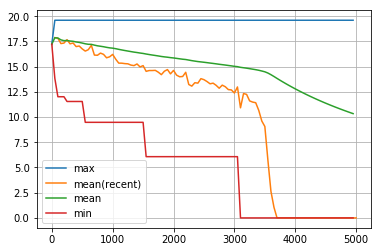

In [0]:
visualize_history(dist_goal_history1[:5000])

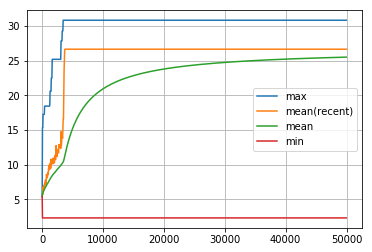

In [0]:
visualize_history(len_route_history1)

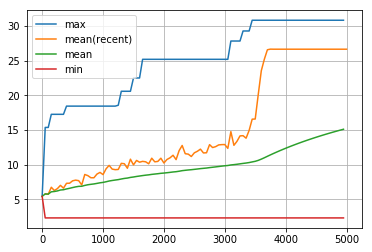

In [0]:
visualize_history(len_route_history1[:5000])

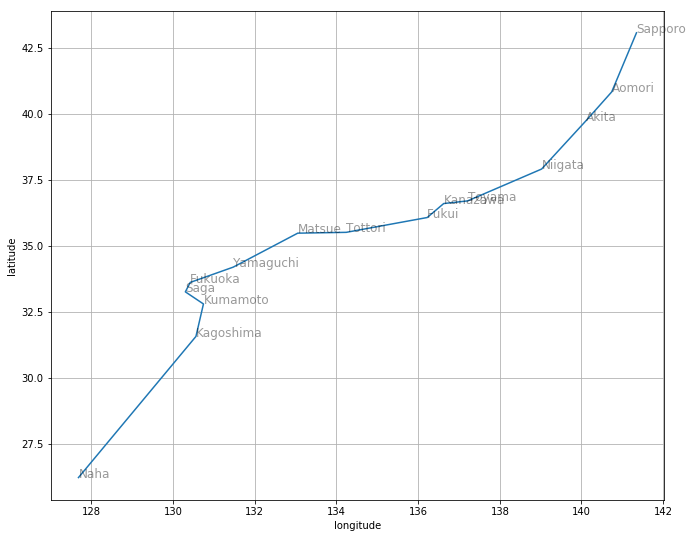

In [0]:
draw_route(best_route1)

In [0]:
pi_pg = pi.copy()
theta_pg = theta.copy()

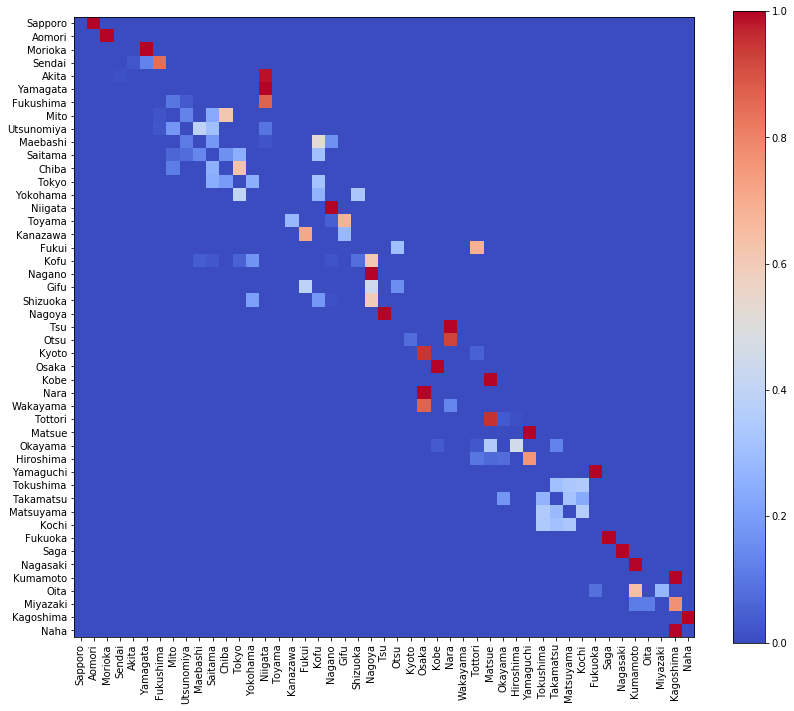

In [0]:
visualize_matrix(pd.DataFrame(pi_pg, columns=location[:, 0]))

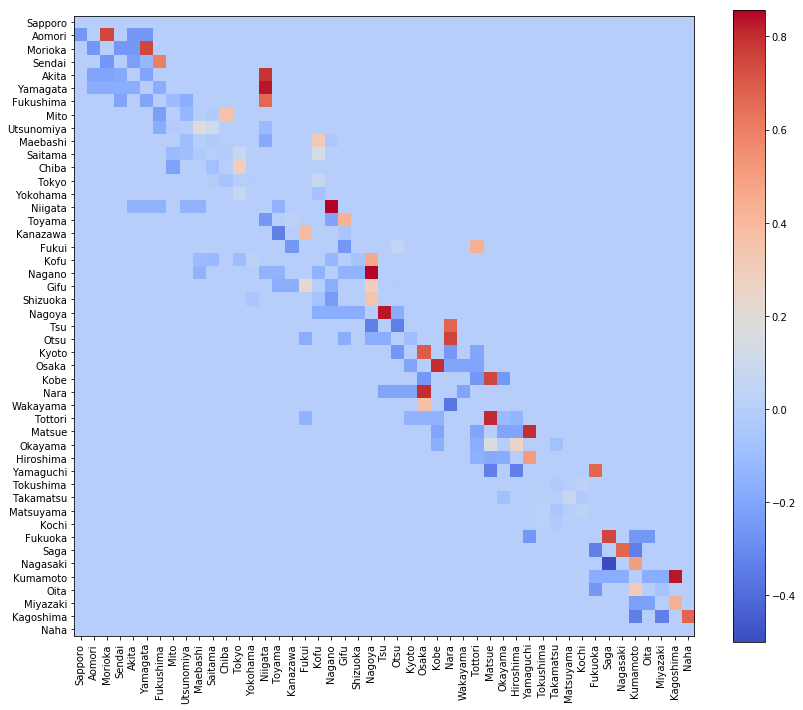

In [0]:
visualize_matrix(pd.DataFrame(pi_pg - pi_zero, columns=location[:, 0]))

# epsilon-greedy法

In [0]:
def generate_Q(theta):
    [m, n] = theta.shape
    Q = np.zeros((m, n))
    rand = np.random.rand(m, n)
    for i in range(m):
        for j in range(n):
            if theta[i, j] == 1:
                Q[i, j] = rand[i, j]
        
    return normalize_pi(Q)

In [0]:
Q_zero = generate_Q(theta_zero)

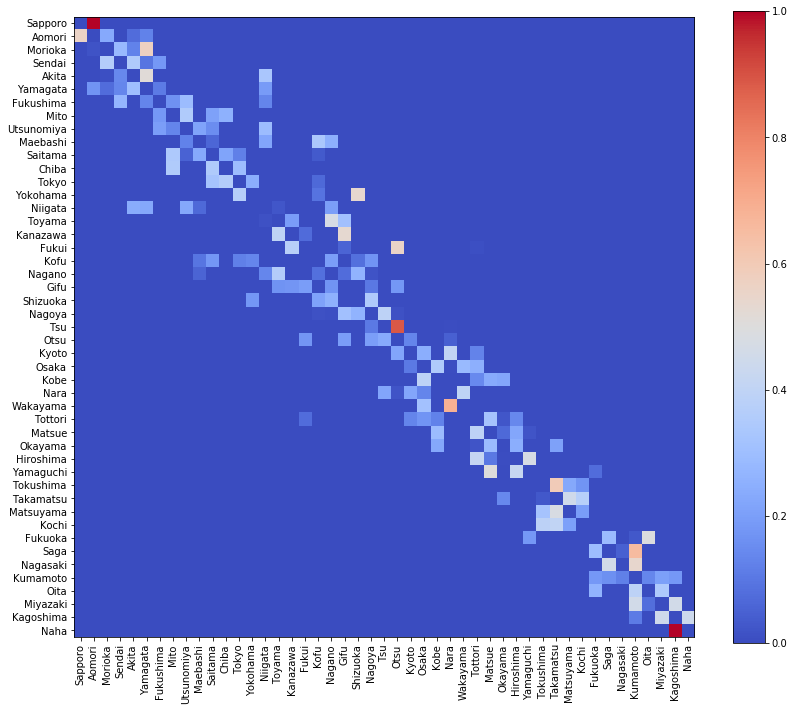

In [0]:
visualize_matrix(pd.DataFrame(Q_zero, columns=location[:, 0]))

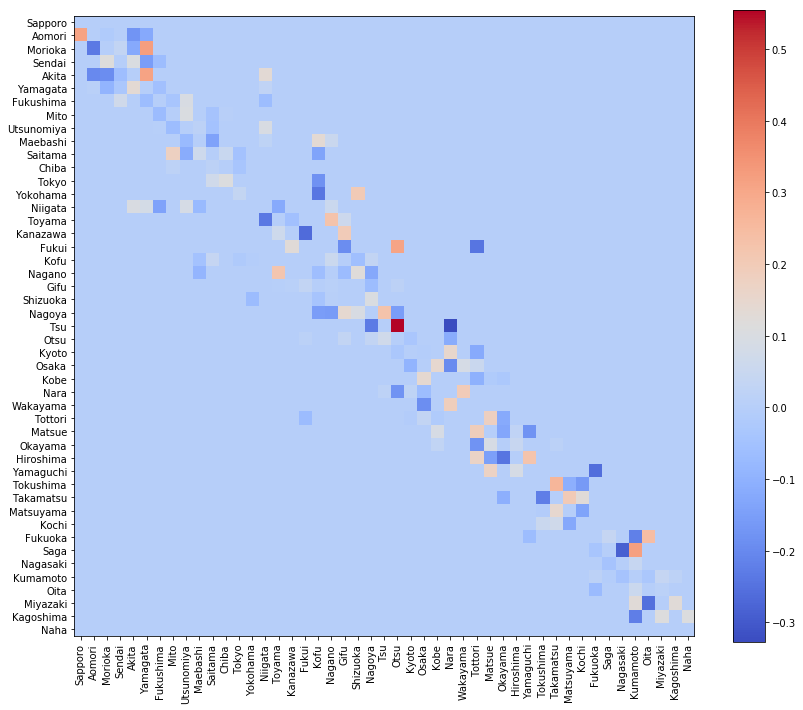

In [0]:
visualize_matrix(pd.DataFrame(Q_zero - pi_zero, columns=location[:, 0]))

In [0]:
def get_next(town, Q, epsilon=0.1):
    if np.random.rand() < epsilon:
        return np.random.choice(range(len(Q)), p=Q[town, :])
    else:
        return np.nanargmax(Q[town, :])

In [0]:
def sarsa(town, Q, prev_t, next_t, reward, eta=0.1, gamma=0.9, goal=46):
    if reward == 1: #dist_mat[town, goal] == 0:
        Q[prev_t, town] = Q[prev_t, town] + eta * (reward - Q[prev_t, town])
    elif reward >= 0:
        Q[prev_t, town] = Q[prev_t, town] + eta * (reward - Q[prev_t, town] + gamma * Q[town, next_t])
    else:
        Q[prev_t, town] = Q[prev_t, town] - eta * Q[prev_t, town]
        
    return normalize_pi(Q)

In [0]:
def explore_epsilon_greedy(Q, epsilon=0.1, eta=0.1, gamma=0.9, start=0, goal=46, min_epsilon=0.01):
    epsilon = max(epsilon, min_epsilon)
    route = [start]
    town = get_next(start, Q, epsilon)
    prev_t = start
    while True:
        if town in route:
            reward = -1
            Q = sarsa(town, Q, prev_t, next_t, reward, eta, gamma)
            break
        elif town == goal:
            reward = 1
            route.append(town)
            Q = sarsa(town, Q, prev_t, next_t, reward, eta, gamma)
            break
        else:
            reward = 0
            route.append(town)
            next_t = get_next(town, Q, epsilon)
            Q = sarsa(town, Q, prev_t, next_t, reward, eta, gamma)
            prev_t = town
            town = next_t
    
    return [route, Q]

In [0]:
%%time
eta = 0.1 # 学習率
gamma = 0.9 # 時間割引率
epsilon = 0.5
Q = Q_zero.copy()

best_dist_goal = 1000000
best_len_route = 1000000

best_route2 = []
dist_goal_history2 = []
len_route_history2 = []
for itera in range(50000):
    epsilon = epsilon * 0.99
    route, Q = explore_epsilon_greedy(Q, epsilon, eta, gamma)
    dist_goal, len_route = evaluate(route)
    dist_goal_history2.append(dist_goal)
    len_route_history2.append(len_route)

    if is_best_ever():
        best_dist_goal = dist_goal
        best_len_route = len_route
        best_route2 = route

CPU times: user 7min 50s, sys: 948 ms, total: 7min 50s
Wall time: 7min 53s


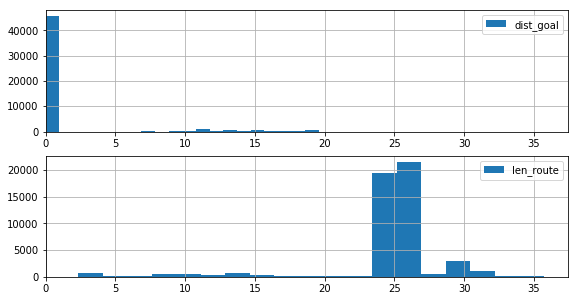

In [0]:
draw_histgrams(dist_goal_history2, len_route_history2)

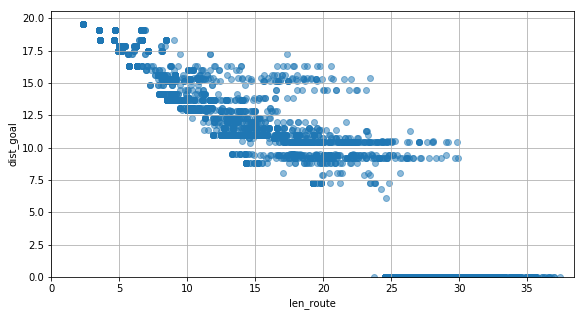

In [0]:
draw_scatter(dist_goal_history2, len_route_history2) 

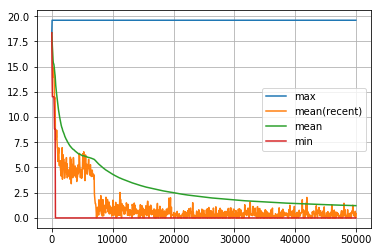

In [0]:
visualize_history(dist_goal_history2)

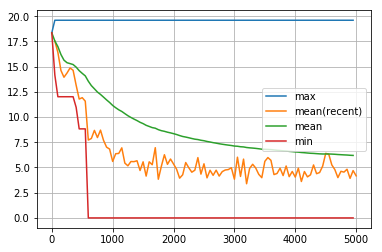

In [0]:
visualize_history(dist_goal_history2[:5000])

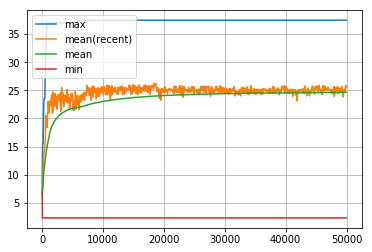

In [0]:
visualize_history(len_route_history2)

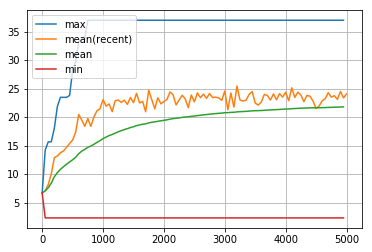

In [0]:
visualize_history(len_route_history2[:5000])

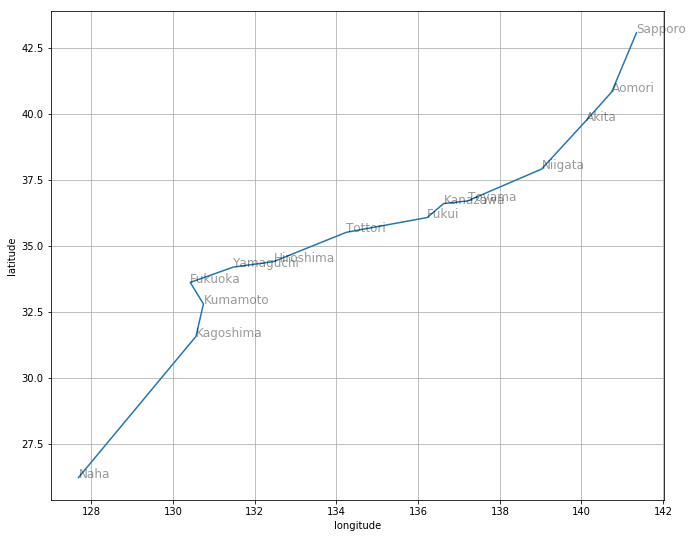

In [0]:
draw_route(best_route2)

In [0]:
Q_eg = Q.copy()

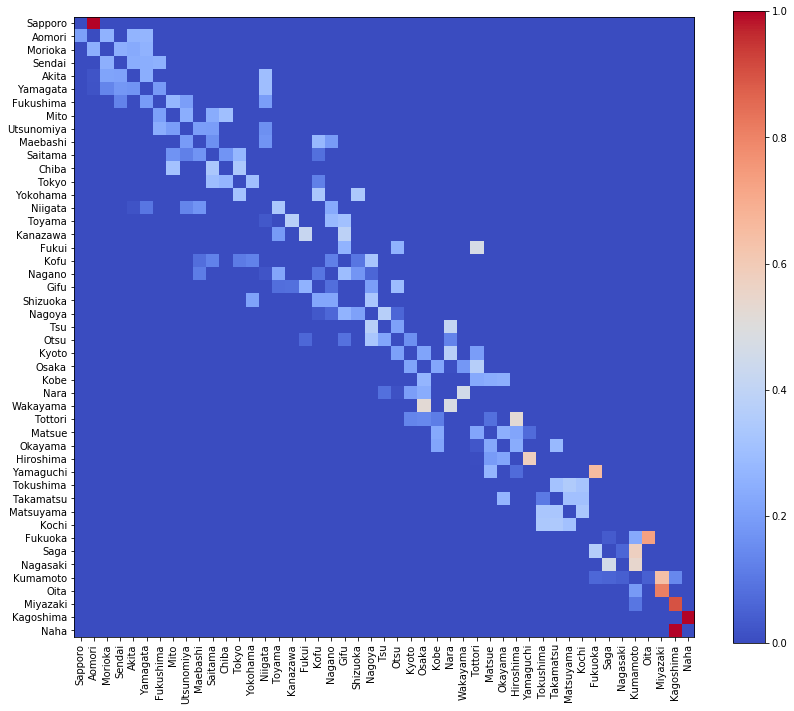

In [0]:
visualize_matrix(pd.DataFrame(Q_eg, columns=location[:, 0]))

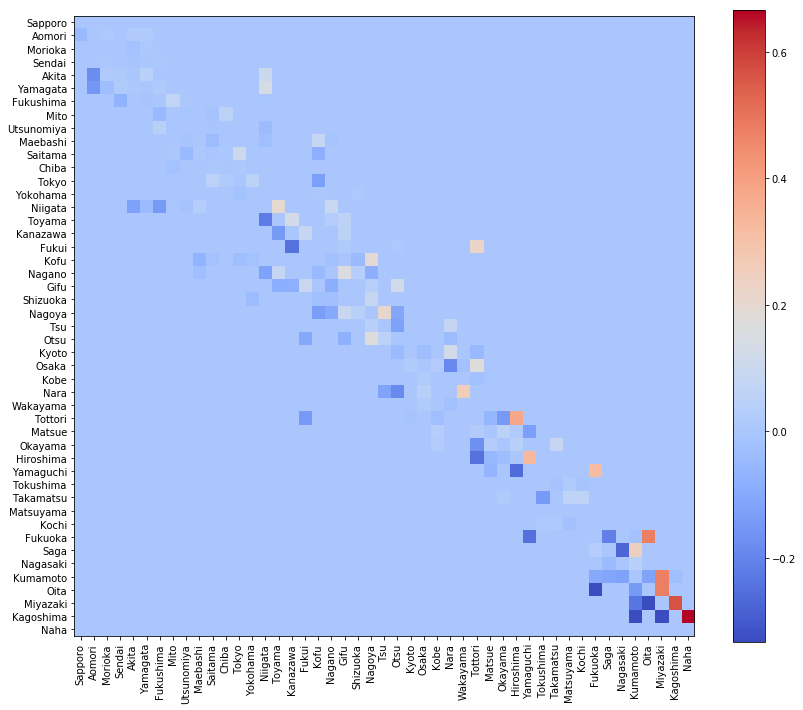

In [0]:
visualize_matrix(pd.DataFrame(Q_eg - pi_zero, columns=location[:, 0]))

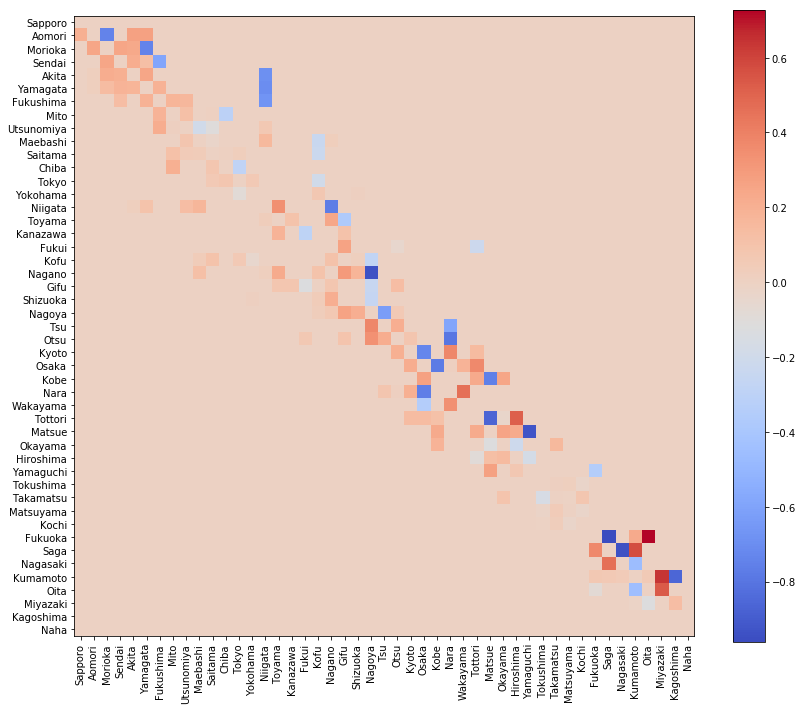

In [0]:
visualize_matrix(pd.DataFrame(Q_eg - pi_pg, columns=location[:, 0]))

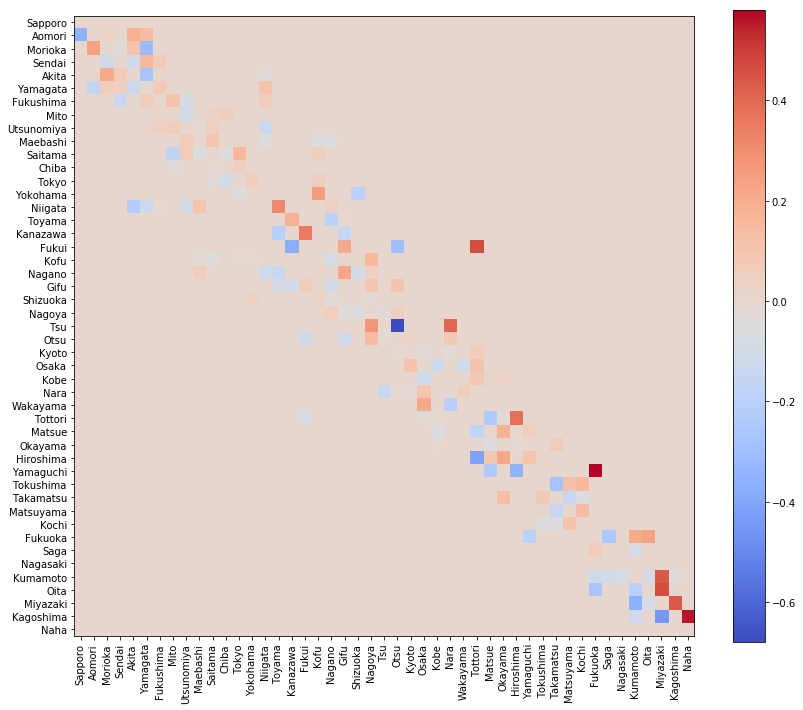

In [0]:
visualize_matrix(pd.DataFrame(Q_eg - Q_zero, columns=location[:, 0]))

# Q-learning

In [0]:
def Q_learning(town, Q, prev_t, reward, eta=0.1, gamma=0.9, goal=46):
    if reward == 1: #dist_mat[town, goal] == 0:
        Q[prev_t, town] = Q[prev_t, town] + eta * (reward - Q[prev_t, town])
    elif reward >= 0:
        Q[prev_t, town] = Q[prev_t, town] + eta * (reward - Q[prev_t, town] + gamma * np.nanmax(Q[town, :]))
    else:
        Q[prev_t, town] = Q[prev_t, town] - eta * Q[prev_t, town]
        
    return normalize_pi(Q)

In [0]:
def explore_Q_learning(Q, epsilon=0.1, eta=0.1, gamma=0.9, start=0, goal=46):
    prev_t = start
    route = [start]
    town = get_next(start, Q, epsilon)
    while True:
        if town in route:
            reward = -1
            Q = Q_learning(town, Q, prev_t, reward, eta, gamma)
            break
        elif town == goal:
            reward = 1 
            route.append(town)
            Q = Q_learning(town, Q, prev_t, reward, eta, gamma)
            break
        else:
            reward = 0
            dist_goal, len_route = evaluate(route)
            if best_dist_goal > dist_goal:
                reward = 1
            route.append(town)
            next_t = get_next(town, Q, epsilon)
            Q = Q_learning(town, Q, prev_t, reward, eta, gamma)
            prev_t = town
            town = next_t
    
    return [route, Q]

In [0]:
%%time
eta = 0.1 # 学習率
gamma = 0.9 # 時間割引率
epsilon = 0.5
Q = Q_zero.copy()

best_dist_goal = 1000000
best_len_route = 1000000

best_route3 = []
dist_goal_history3 = []
len_route_history3 = []
for itera in range(50000):
    epsilon = epsilon * 0.99
    route, Q = explore_Q_learning(Q, epsilon, eta, gamma)
    dist_goal, len_route = evaluate(route)
    dist_goal_history3.append(dist_goal)
    len_route_history3.append(len_route)

    if is_best_ever():
        best_dist_goal = dist_goal
        best_len_route = len_route
        best_route3 = route

CPU times: user 9min 50s, sys: 1.41 s, total: 9min 52s
Wall time: 9min 54s


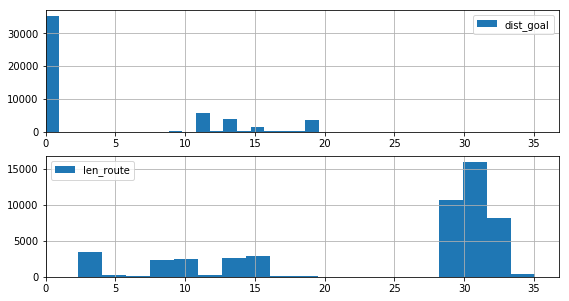

In [0]:
draw_histgrams(dist_goal_history3, len_route_history3)

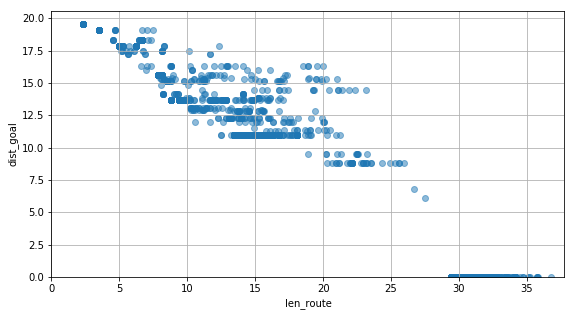

In [0]:
draw_scatter(dist_goal_history3, len_route_history3) 

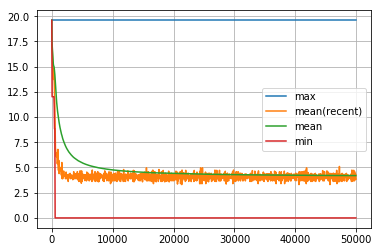

In [0]:
visualize_history(dist_goal_history3)

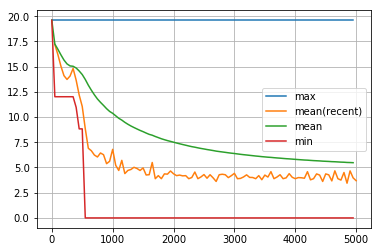

In [0]:
visualize_history(dist_goal_history3[:5000])

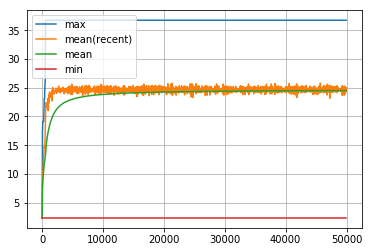

In [0]:
visualize_history(len_route_history3)

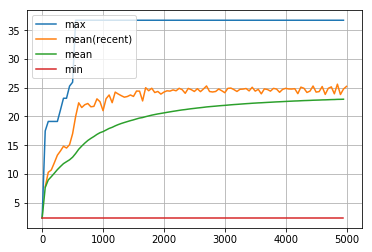

In [0]:
visualize_history(len_route_history3[:5000])

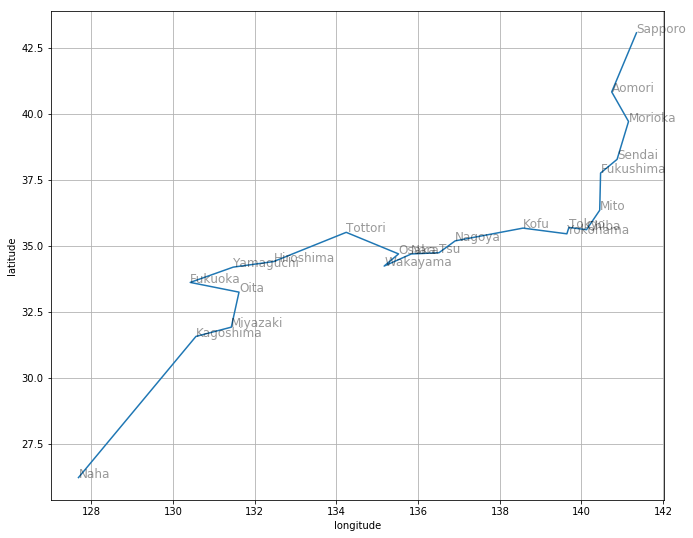

In [0]:
draw_route(best_route3)

In [0]:
Q_qlearn = Q.copy()

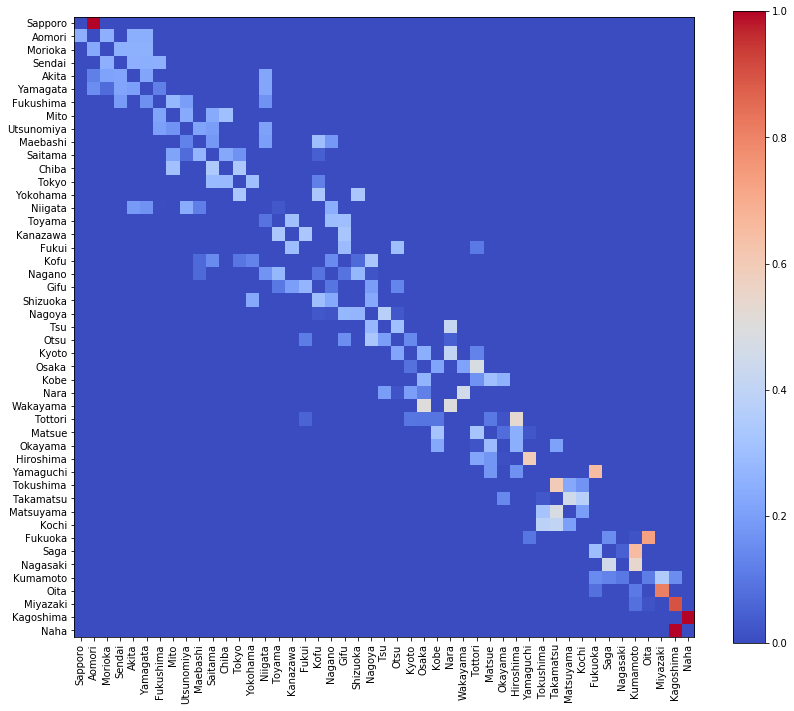

In [0]:
visualize_matrix(pd.DataFrame(Q_qlearn, columns=location[:, 0]))

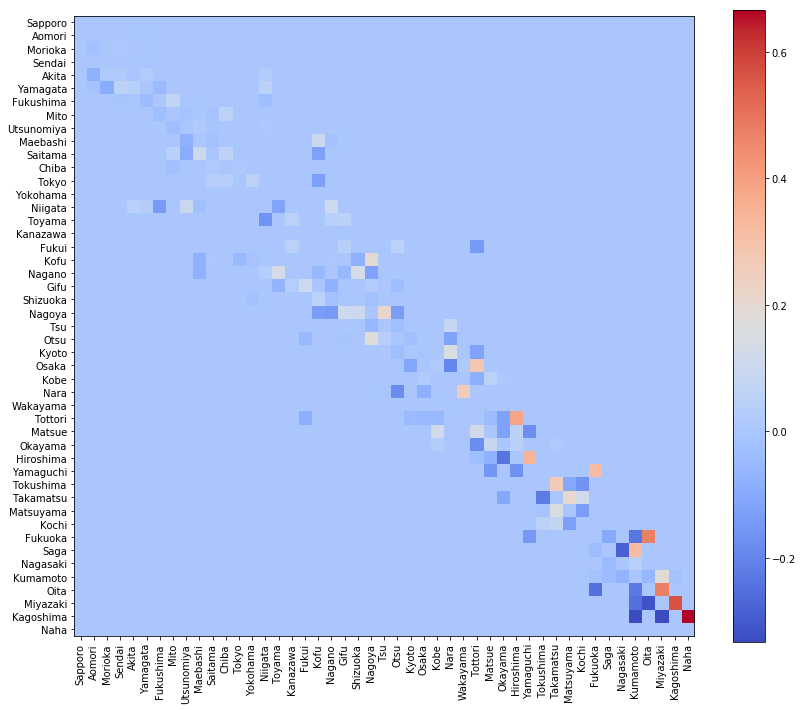

In [0]:
visualize_matrix(pd.DataFrame(Q_qlearn - pi_zero, columns=location[:, 0]))

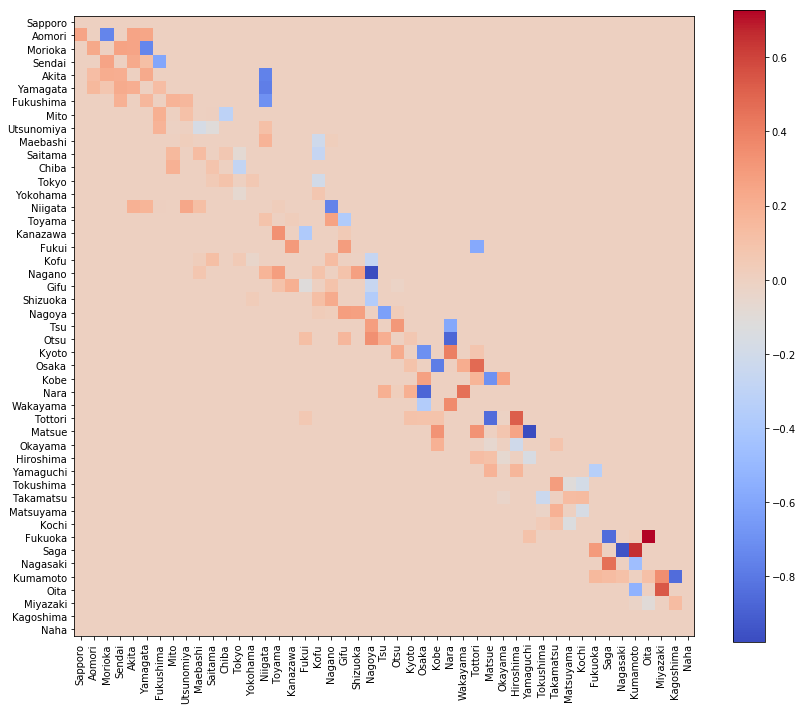

In [0]:
visualize_matrix(pd.DataFrame(Q_qlearn - pi_pg, columns=location[:, 0]))

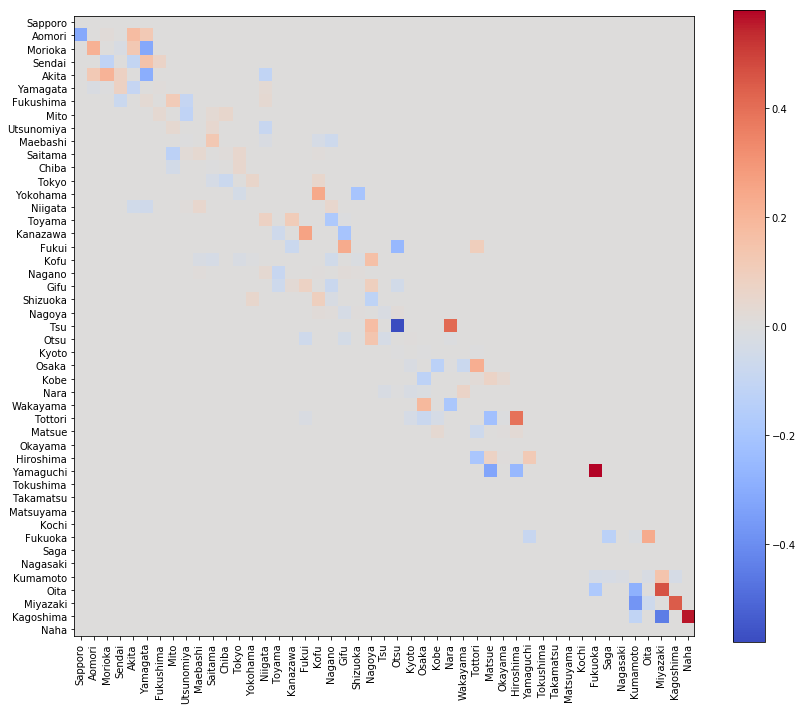

In [0]:
visualize_matrix(pd.DataFrame(Q_qlearn - Q_zero, columns=location[:, 0]))

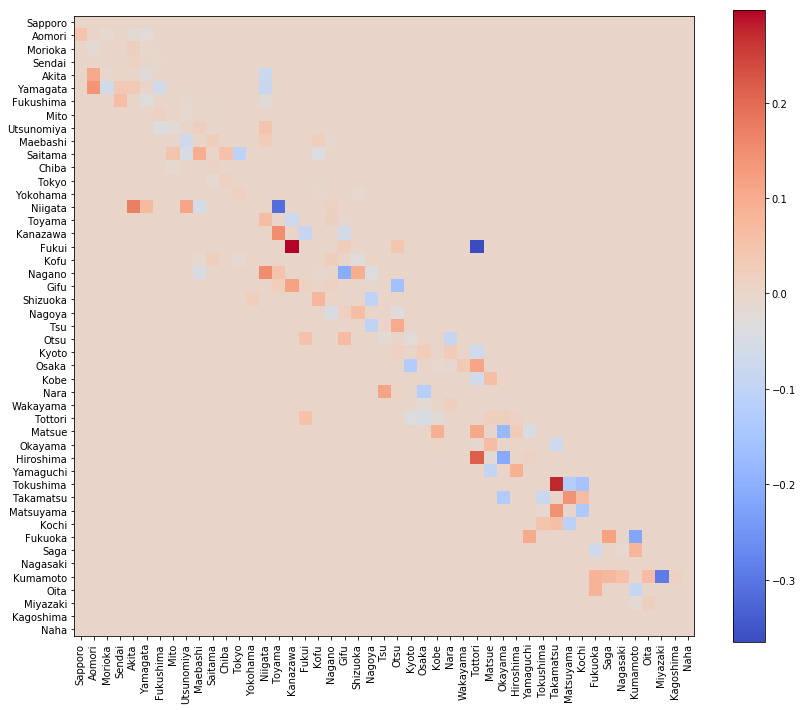

In [0]:
visualize_matrix(pd.DataFrame(Q_qlearn - Q_eg, columns=location[:, 0]))

In [0]:
evaluate(best_route0)

[6.072527664070378, 20.768304471253185]

In [0]:
evaluate(best_route1)

[0.0, 23.965870640814234]

In [0]:
evaluate(best_route2)

[0.0, 23.710297513873968]

In [0]:
evaluate(best_route3)

[0.0, 29.45150866624414]